In [1]:
import geopandas
import pandas
import starepandas
import pystare
import shapely
import matplotlib.pyplot as plt

# Points

## Creating a naive dataframe

In [2]:
cities = ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas']
countries = ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela']
latitudes = [-34.58, -15.78, -33.45, 4.60, 10.48]
longitudes = [-58.66, -47.91, -70.66, -74.08, -66.86]
data =  {'City': cities,  'Country': countries, 
         'Latitude': latitudes, 'Longitude': longitudes}

df = pandas.DataFrame(data)

## Creating a geodataframe

In [3]:
geom = geopandas.points_from_xy(df.Longitude, df.Latitude)
gdf = geopandas.GeoDataFrame(df, geometry=geom)
gdf

,City,Country,Latitude,Longitude,geometry
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66000 -34.58000)
1,Brasilia,Brazil,-15.78,-47.91,POINT (-47.91000 -15.78000)
2,Santiago,Chile,-33.45,-70.66,POINT (-70.66000 -33.45000)
3,Bogota,Colombia,4.60,-74.08,POINT (-74.08000 4.60000)
4,Caracas,Venezuela,10.48,-66.86,POINT (-66.86000 10.48000)


## Creating a STARE indices

In [4]:
# Those are all identical
stare = starepandas.stare_from_xy(df.Longitude, df.Latitude, level=5)
stare = starepandas.stare_from_xy_df(gdf, n_workers=2, level=5)
stare = starepandas.stare_from_gdf(gdf, level=5)

sdf = starepandas.STAREDataFrame(gdf)
sdf.set_stare(stare, inplace=True)

In [5]:
stare

array([2663379193440875365, 2867415364672350629, 2723774768829278533,
       2667981979956219493, 2494081632617553381])

In [6]:
trixels = sdf.make_trixels()
sdf.set_trixels(trixels, inplace=True)

In [7]:
sdf.stare

0    2663379193440875365
1    2867415364672350629
2    2723774768829278533
3    2667981979956219493
4    2494081632617553381
Name: stare, dtype: int64

In [8]:
sdf.geometry

0    POINT (-58.66000 -34.58000)
1    POINT (-47.91000 -15.78000)
2    POINT (-70.66000 -33.45000)
3      POINT (-74.08000 4.60000)
4     POINT (-66.86000 10.48000)
Name: geometry, dtype: geometry

## Some plotting

<class 'starepandas.staredataframe.STAREDataFrame'>


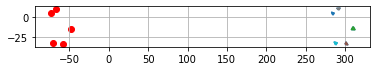

In [9]:
fig, ax = plt.subplots()
ax.grid(True)

sdf.plot(ax=ax)
#sdf.plot(ax=ax, trixels=True)
sdf.plot(ax=ax, trixels=False, color='r')

df = sdf.set_geometry('trixels', inplace=False)
df = df[df.geometry.is_empty==False]
df = df.set_geometry(df.geometry.boundary)
df.plot(ax=ax, column='City')

sdf.plot(ax=ax, column='City')
print(type(df))

# From granule

## Bootstrap

In [10]:
fname = '../tests/data/granules/MOD05_L2.A2019336.0000.061.2019336211522.hdf'
modis = starepandas.read_granule(fname, 
                                 add_stare=True,
                                 adapt_resolution=True,
                                 track_first=False)

## Use Sidecar

In [11]:
modis = starepandas.read_granule(fname, sidecar=True)
modis

,stare,Scan_Start_Time,Solar_Zenith,Solar_Azimuth,Sensor_Zenith,Sensor_Azimuth,Water_Vapor_Infrared
0,4298473764500464809,8.493984e+08,14709,-2296,6534,-8952,-9999
1,4298458168380511209,8.493984e+08,14700,-2354,6472,-8980,-9999
2,4297394569014717897,8.493984e+08,14692,-2410,6411,-9008,-9999
3,4297300698872999369,8.493984e+08,14684,-2464,6351,-9034,-9999
4,4297290857922121161,8.493984e+08,14676,-2516,6291,-9059,-9999
...,...,...,...,...,...,...,...
109615,3727686638370615689,8.493987e+08,12157,-7468,6223,4800,-9999
109616,3727661374545790857,8.493987e+08,12147,-7505,6282,4772,-9999
109617,3727838256925064969,8.493987e+08,12137,-7544,6342,4743,-9999
109618,3727843063731949801,8.493987e+08,12126,-7583,6402,4714,-9999


# Polygons

## US State

In [12]:
us = geopandas.read_file('../tests/data/tl_2017_us_state.gpkg')
us = us.to_crs('EPSG:4326')
us['geom_simple'] = us.simplify(0.002)
us.set_geometry('geom_simple', inplace=True)

In [13]:
stare = starepandas.stare_from_gdf(us, level=9, force_ccw=True)
us = starepandas.STAREDataFrame(us, stare=stare)
us.set_trixels(inplace=True)
us._geometry_column_name

'geometry'

<AxesSubplot:>

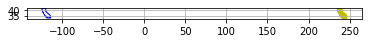

In [14]:
fig, ax = plt.subplots()
ax.grid(True)

state = us[us.NAME=='California']
state.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=0)
state.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)

## Africa

In [15]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.sort_values(by='name', inplace=True)
africa = world[world.continent=='Africa']

In [16]:
stare = starepandas.stare_from_gdf(africa, level=7, force_ccw=True)
africa = starepandas.STAREDataFrame(africa, stare=stare)
trixels = africa.make_trixels()
africa.set_trixels(trixels, inplace=True)

In [17]:
africa

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,stare,trixels
82,40969443,Africa,Algeria,DZA,609400.0,"POLYGON ((-8.68440 27.39574, -8.66512 27.58948...","[4485585228861014020, 4490651778441805829, 449...","(POLYGON ((0 35.26439016892547, 355.7333170379..."
74,29310273,Africa,Angola,AGO,189000.0,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4...","[4464228315003092999, 4464263499375181831, 446...",(POLYGON ((12.02285745040538 -4.04283833785288...
54,11038805,Africa,Benin,BEN,24310.0,"POLYGON ((2.69170 6.25882, 1.86524 6.14216, 1....","[4415849803380948999, 4416096093985570823, 441...",(POLYGON ((2.289469692742385 6.638049841417038...
49,2214858,Africa,Botswana,BWA,35900.0,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827...","[21392098230009861, 21955048183431173, 2589569...",(POLYGON ((24.29559100067425 -19.4708859004967...
65,20107509,Africa,Burkina Faso,BFA,32990.0,"POLYGON ((-5.40434 10.37074, -5.47056 10.95127...","[4500503402626678790, 4500644140115034118, 450...",(POLYGON ((0.3368114829013973 14.0577643783033...
75,11466756,Africa,Burundi,BDI,7892.0,"POLYGON ((30.46967 -2.41385, 30.52766 -2.80762...","[4393402173988274183, 4393437358360363015, 439...",(POLYGON ((29.82199688829401 -2.10227991283114...
57,24994885,Africa,Cameroon,CMR,77240.0,"POLYGON ((14.49579 12.85940, 14.89336 12.21905...","[4413668372311441414, 4413809109799796742, 441...","(POLYGON ((11.63286203733277 5.39077570594473,..."
66,5625118,Africa,Central African Rep.,CAF,3206.0,"POLYGON ((27.37423 5.23394, 27.04407 5.12785, ...","[4368491638549381126, 4521614025879977990, 452...","(POLYGON ((15.35858327345755 4.85020584727882,..."
15,12075985,Africa,Chad,TCD,30590.0,"POLYGON ((23.83766 19.58047, 23.88689 15.61084...","[4594234569871327237, 4596486369685012485, 460...",(POLYGON ((20.83798131309756 11.25167752871018...
67,4954674,Africa,Congo,COG,30270.0,"POLYGON ((18.45307 3.50439, 18.39379 2.90044, ...","[4432949408216121350, 4433230883192832006, 443...",(POLYGON ((14.68005794817119 0.278643032870233...


<AxesSubplot:>

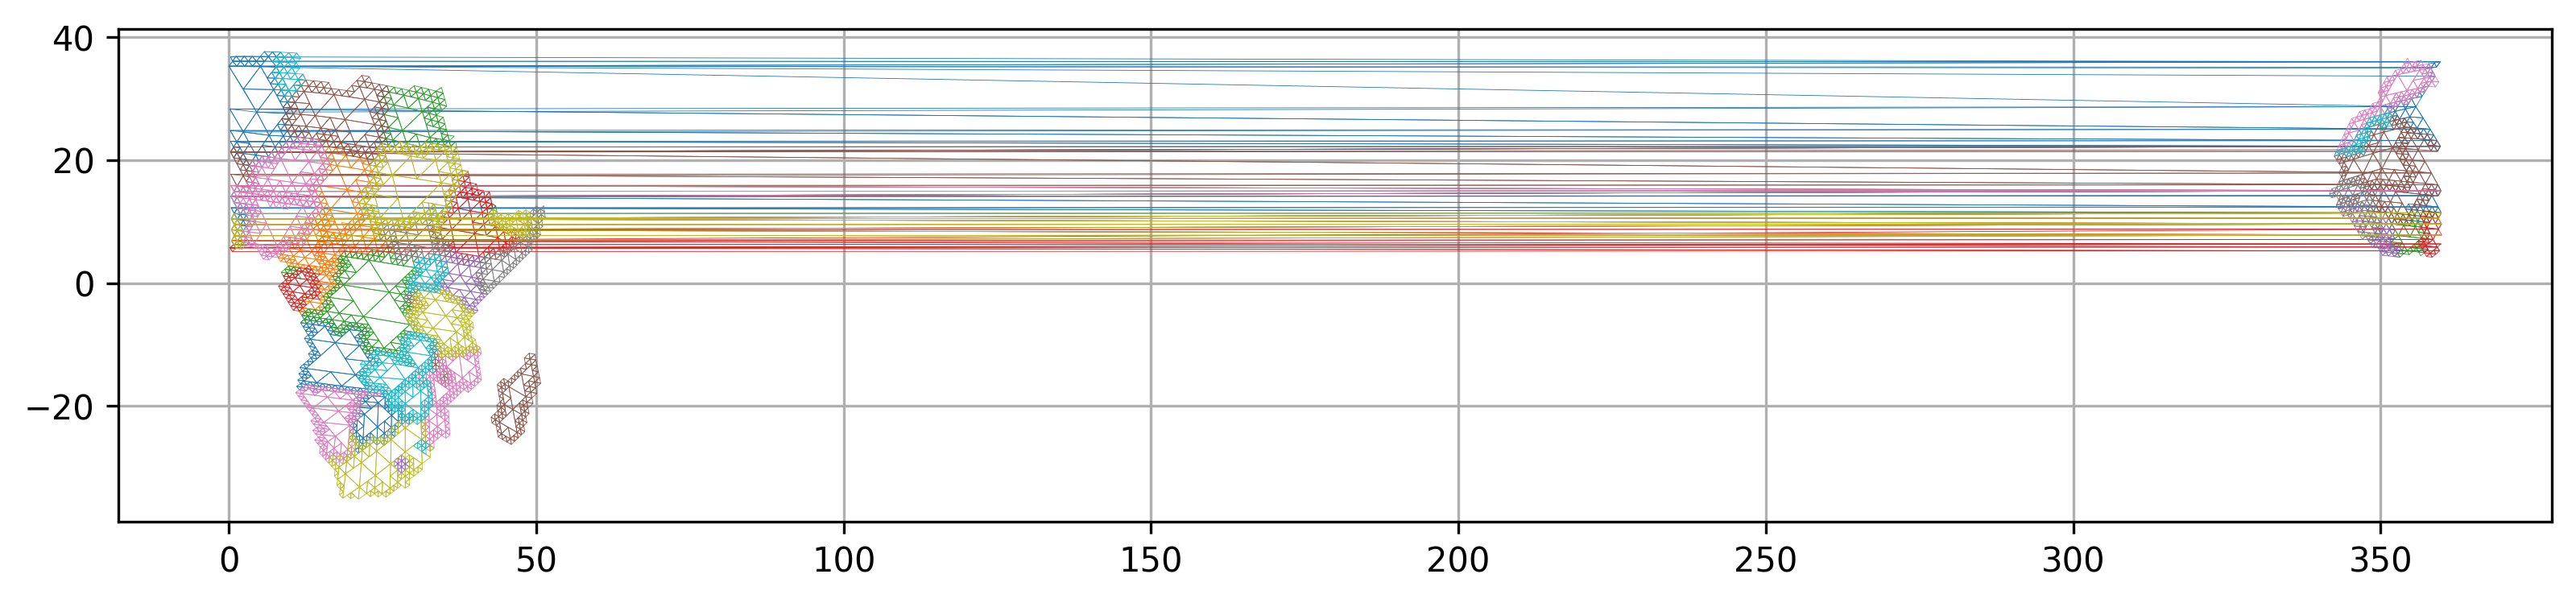

In [18]:
fig, ax = plt.subplots(figsize=(13,5), dpi=300)
ax.grid(True)

africa.plot(ax=ax, trixels=True, boundary=True, column='name', linewidth=0.2)

## Holes in RSA

In [19]:
rsa = africa[africa.name=='South Africa']

<AxesSubplot:>

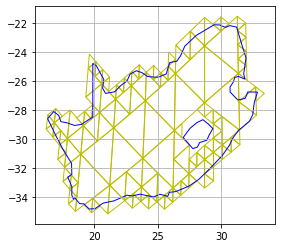

In [20]:
fig, ax = plt.subplots()
ax.grid(True)

rsa.plot(ax=ax, trixels=True, boundary=True, color='y', lw=1, zorder=0)
rsa.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', lw=1, zorder=1)

In [21]:
p = rsa.iloc[0].geometry
interior = starepandas.from_ring(p.interiors[0], level=12, force_ccw=False)

## Puerto Rico (GPKG)

In [22]:
file = '../tests/data/caribbean.gpkg'
gdf = geopandas.read_file(file)

# Sanitation
gdf.rename(columns={'NAME_0': "name"}, inplace=True)
gdf.sort_values(by='name', inplace=True)
gdf.set_index('ISO', inplace=True)
gdf = gdf[['name', 'geometry']]

# Adding simple geom
gdf['geom_simple'] = gdf.simplify(0.001)
gdf.set_geometry('geom_simple', inplace=True)

In [23]:
stare = starepandas.stare_from_gdf(gdf, level=11, force_ccw=True)
sdf = starepandas.STAREDataFrame(gdf, stare=stare)

In [24]:
trixels = sdf.make_trixels()
sdf.set_trixels(trixels, inplace=True)

<AxesSubplot:>

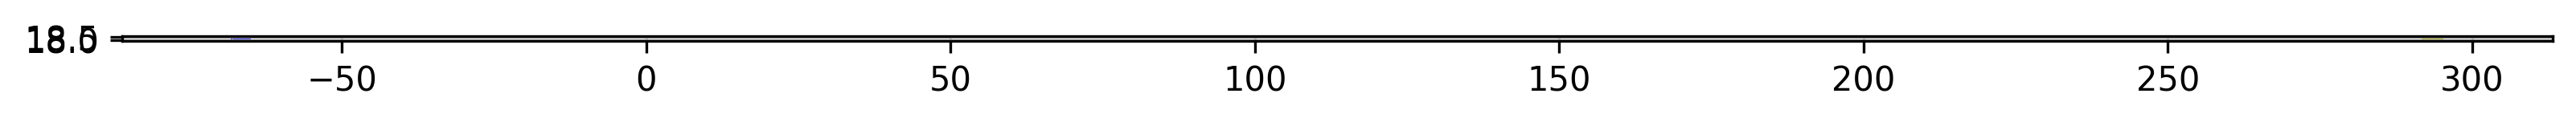

In [25]:
fig, ax = plt.subplots(figsize=(13,5), dpi=300)
ax.grid(True)

pr = sdf[sdf['name']=='Puerto Rico']
pr.plot(ax=ax, trixels=True, color='y', lw=1, zorder=0)
pr.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', lw=1, zorder=1)